This notebook plots the __native and non-native contacts__ for molecule A(Protein) and molecule B(RNA) from given files containing list of files containing contacts per frame from MD simulation. This notbook can be divided into following modules:
1. Read all the atomic contacts per frame from given list of file
2. Group the atomic contacts according to the region of atoms 
  - Groups for Protein --> backbone, sidechain
  - Groups for Nucleotides --> Sugar, phosphate, backbone
3. Plot the group contacts 

In [1]:
# Import all the required libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

All the __inputs from user__ can be fed into below cell. Below is the list of all input parameters required from the user:  
##### Required inputs
1. File with list of files containing native contacts per frame (first few frames from MD simulation)
2. File with list of files containing non-native contacts per frame (last few frames from MD simulation)
3. Directory path where all the files are stored
4. Molecule A (Protein) sequence
5. Molecule B (RNA) sequence
6. Basename for final dataframe csv and figure 
7. Threshold for percentage of contacts to filter
8. Frames for native contacts
9. Total number of frames (conformations) used for this analysis, i.e., native + non-native  

##### Optional inputs
10. The CSV file written by same program but for other analysis like mutant & wild-type for easy comparison


In [2]:
# Required inputs
nat = '../nat.txt'
nonnat = '../nonnat.txt'
directory = '/home/hdhondge/MD_Musashi/Prev_Analysis/Annealing/5X3Z_simA/Analysis/contacts'
# directory = '/home/hdhondge/MD_Musashi/Prev_Analysis/Annealing/5X3Z_mod_simA/Analysis/contacts'
prot_seq = 'KKIFVGGLSVNTTVEDVKXYFEQFGKVDDAMLMFDKTTNRXRGFGFVTFESEDIVEKVCEIXFXEINNKMVECKKAQP'
nucl_seq = 'UAG'
basename = 'newType'
threhold_percent = 10
total_frames = 15

# optional inputs --> comment out the below line if not in use by adding a # at the beginning
other_plot_file = '/home/hdhondge/MD_Musashi/Prev_Analysis/Annealing/5X3Z_mod_simA/Analysis/contacts/MutType.csv'


The below cell will have all the necessary functions to read, group, compare and plot the contacts from given files.

In [3]:

# Function to split the contact column into Prot and Nucleic part
def split_contact_labelling(df):
    df[["bl", "Prot", "Nucl"]] = df["Contact"].str.split(':', expand=True)
    df = df.drop("bl", axis='columns')
    df = add_residue_label(df, prot_seq, nucl_seq) 
    return df


# Function to add one-letter residue labels and atomic group (bb and sc for amino acid; sg,ph and bs for nucleotide)
def add_residue_label(df, seq_prot, seq_nucl):
    seq_nucl = seq_prot + seq_nucl
    
    phosphate = ['OP1', 'OP2', 'P', 'OP3', 'OP4']
    sugar = ['O2\'', 'O3\'', 'C1\'', 'C2\'', 'C3\'', 'C4\'', 'C5\'', 'O4\'', 'O5\'']
    backbone = ['N', 'CA', 'C', 'O']

    for i, row in df.iterrows():
        prev_prot = str(df.at[i, 'Prot']).split('@')
        prev_nucl = str(df.at[i, 'Nucl']).split('@')
        prot_atom_group = 'bb' if prev_prot[1] in backbone else 'sc'
        nucl_atom_group = 'ph' if prev_nucl[1] in phosphate else None
        if nucl_atom_group == None:
            nucl_atom_group = 'sg' if prev_nucl[1] in sugar else 'bs'
            
        next_prot = prev_prot[0] + seq_prot[int(prev_prot[0])-1] +'@' + prot_atom_group #+ '_' + prev_prot[1]
        next_nucl = prev_nucl[0] + seq_nucl[int(prev_nucl[0])-1] +'@' + nucl_atom_group #+ '_' + prev_nucl[1]

        if int(prev_prot[0]) < 10:
            next_prot = '0'+next_prot
        
        if int(prev_nucl[0]) < 10:
            next_nucl = '0'+next_nucl

        df.at[i, 'Prot'] = next_prot
        df.at[i, 'Nucl'] = next_nucl   
    return df



# group together
def df_group_contacts(df):
    group_df = df.groupby(['Prot', 'Nucl']).agg(pd.Series.tolist)
    group_df = group_df.reset_index()

    for i,row in group_df.iterrows():
        prev_fract = group_df.at[i, 'Frac.']
        group_df.at[i, 'Frac.'] = sum(prev_fract)/len(prev_fract)
    return group_df



# Functionto create dataframe from the file
def file_to_df(file):
    data = open(file).read().split('\n')
    header = ['Contact', 'Nframes', 'Frac.', 'Avg', 'Stdev']    # column names for contacts
    df = pd.DataFrame(columns=header)
    for a in data:
        if a.startswith('#') or a == '':
            continue
        a = a.split()
        new = [int(a[0]), str(a[1]), int(a[2]), float(a[3]), float(a[4]), float(a[5])]  
        
        df.loc[len(df)] = new[1:]         # Columns to store in dataframe
    
    df = df.astype({"Contact": str, "Nframes": int, "Frac.": float, "Avg": float, "Stdev": float})
    
    # Calling other functions inside
    df = split_contact_labelling(df)
    
    # Grouping the prot and nucleic contacts according to atomic region
    df = df_group_contacts(df[['Prot', 'Nucl', 'Frac.']]) 
    return df


def merge_and_add_numFrame(dfa, new_dict):
    for i,row in dfa.iterrows():
        new_key = dfa.at[i, 'Prot'] + '_' + dfa.at[i, 'Nucl']
        if new_key in new_dict.keys():
            new_dict[new_key] += 1
        else:
            new_dict[new_key] = 1
    return new_dict


# Function to add extra rows in plot for easy comparison with other (mutant) plot
def add_rows_from_twin_df(file, df):
    twin_df = pd.read_csv(file, index_col=None)
    
    # Get unique values for Protein and nucleic acid atomic regions
    prot_twin = list(set(twin_df['Prot'].tolist()))
    nucl_twin = list(set(twin_df['Nucl'].tolist()))
    
    # Find only values to add in working dataframe to make same x and y axis labels
    prot_add, nucl_add = [], []
    for a in prot_twin:
        if a not in list(set(df['Prot'].tolist())):
            prot_add.append(a)

    for a in nucl_twin:
        if a not in list(set(df['Nucl'].tolist())):
            nucl_add.append(a)
    
    # add new rows with extra Protein and nucleic acid regions in working dataframe
    if len(prot_add) == len(nucl_add):
        for a in range(len(prot_add)):
            new_row = {'Prot': prot_add[a], 'Nucl': nucl_add[a], 'native': 3, 'Frames': np.NaN}
            df = df.append(new_row, ignore_index=True)
    elif len(prot_add) > len(nucl_add):
        if len(nucl_add) == 0:
            nucl_add.append(df.at[0, 'Nucl'])
        for a in range(len(prot_add)):
            if len(nucl_add) > a:
                new_row = {'Prot': prot_add[a], 'Nucl': nucl_add[a], 'native': 3, 'Frames': np.NaN}
            else:
                new_row = {'Prot': prot_add[a], 'Nucl': nucl_add[0], 'native': 3, 'Frames': np.NaN}
            df = df.append(new_row, ignore_index=True)
    elif len(prot_add) < len(nucl_add):
        if len(prot_add) == 0:
            prot_add.append(df.at[0, 'Prot'])
        for a in range(len(nucl_add)):
            if len(prot_add) > a:
                new_row = {'Prot': prot_add[a], 'Nucl': nucl_add[a], 'native': 3, 'Frames': np.NaN}
            else:
                new_row = {'Prot': prot_add[0], 'Nucl': nucl_add[a], 'native': 3, 'Frames': np.NaN}
            df = df.append(new_row, ignore_index=True)
    return df


# Function to plot the contacts --> This function is not in use currently
def plot_contacts_per_nt(df, label_col, plot_col):
    plot_labels = df.pivot('Prot', 'Nucl', label_col)
    nt_cont = df.pivot('Prot', 'Nucl', plot_col)
    f, ax = plt.subplots(figsize=(25, 18))
    cmap=['Blue', 'Green', 'Red', 'Yellow', 'Pink', 'Purple', 'Orange'],
    sns.heatmap(nt_cont, annot=plot_labels, fmt='.2f', cmap=['Blue', 'Green', 'Orange'], \
                linewidths=1.0, ax=ax, linecolor='grey', annot_kws={"size": 18, 'rotation':0},\
                cbar_kws={'label': 'Color bar'}, vmin=0, vmax=2) #, 'ticks': [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]



The following cell reads all the contacts per frame provided by the user, and stores them into separate dataframes in using two dictionaries(ref_contacts and all_contacts). 


In [4]:
os.chdir(directory)

# Getting per frame native contacts information 
ref_contacts = {}
for nl, l in enumerate(open(nat).readlines()):
    contactfile = l.split()#[0]
    if contactfile == []:
        continue 
    else:
        contactfile = contactfile[0] 
    ref_contacts['frame'+ str(len(ref_contacts))] = file_to_df(contactfile)

# getting per frame  native + nonnative contacts information
all_contacts = {}  
for a in ref_contacts:
    all_contacts[a] = ref_contacts[a]

for nl, l in enumerate(open(nonnat).readlines()):
    contactfile = l.split()#[0]
    if contactfile == []:
        continue 
    else:
        contactfile = contactfile[0] 
    all_contacts['frame'+ str(len(all_contacts))] = file_to_df(contactfile)


The following cell groups the atomic contacts according to their region and add labels to the contacts. The contacts stored in a dataframe in following format:
- __02K@sc_81G@bs__ --> Atoms from molecule A and molecule B are separated by an underscore '_' ; The residue information and atomic group are separated by @ 
  - __sidechain of Lysine (K) from position 02__ is in contact with __base of Guanine from position 81__

In [5]:
# grouping the atomic contacts according to their region
group_ref, group_all = {}, {}
for a in list(ref_contacts.keys()):
    group_ref = merge_and_add_numFrame(ref_contacts[a], group_ref)

for a in group_ref:
    group_all[a] = group_ref[a]

for a in list(all_contacts.keys()):
    if a in list(ref_contacts.keys()):
        continue
    group_all = merge_and_add_numFrame(all_contacts[a], group_all)


Compare and assign a label as follows:
1. __0 for conserved native__ contacts, 
2. __1 for lost native__ contacts and 
3. __2 for non-native__ contacts.



In [6]:
non_nat = pd.DataFrame(group_all.items(), columns=['Contact', 'Frames'])

non_nat['native'] = np.where(non_nat['Frames'] < 0, None, None)

for i,row in non_nat.iterrows():
    if non_nat.at[i, 'native'] != None:
        print('Error, somthing wrong. Please check inputs')
        break
    prev_contact = non_nat.at[i, 'Contact']
    if (prev_contact in group_ref) and (group_all[prev_contact] > group_ref[prev_contact]):
        non_nat.at[i, 'native'] = 0
    elif (prev_contact in group_ref) and (group_all[prev_contact] == group_ref[prev_contact]):
        non_nat.at[i, 'native'] = 1
    elif prev_contact not in group_ref.keys():
        non_nat.at[i, 'native'] = 2

non_nat[["Prot", "Nucl"]] = non_nat["Contact"].str.split('_', expand=True)

Compute the percentage from number of frames the contact present in. Apply the thrshold for filtering the contacts.  
Optionally, adds the extra rows for `Prot` and `Nucl` columns based on the given input named other_plot_file.
And finally writes the last dataframe to be plotted in a csv file.


In [7]:
all_contacts = non_nat[['Prot', 'Nucl', 'native', 'Frames']]

# Compute percentage of frames the contact is present in
all_contacts['Frames'] = all_contacts['Frames']*100 / total_frames

# Filter the dataframe using the threshold percentage provided by user
df = all_contacts[all_contacts['Frames'] >= threhold_percent ]

# add any contacts if required to make the columns/cells as of other plot
if 'other_plot_file' in locals(): 
    df = add_rows_from_twin_df(other_plot_file, df)

# Write the dataframe to a csv file
df.to_csv(basename + '.csv', index=False) 


<ipython-input-7-cd5a486adab7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_contacts['Frames'] = all_contacts['Frames']*100 / total_frames



Plot the compared contacts according to the percentage of found contacts in number of frames and color different for different labels.
Colors used in the plots are :
- __Green__ for __conserved native__ contacts
- __Red__ for __lost native__ contacts
- __Blue__ for __non-native__ contacts


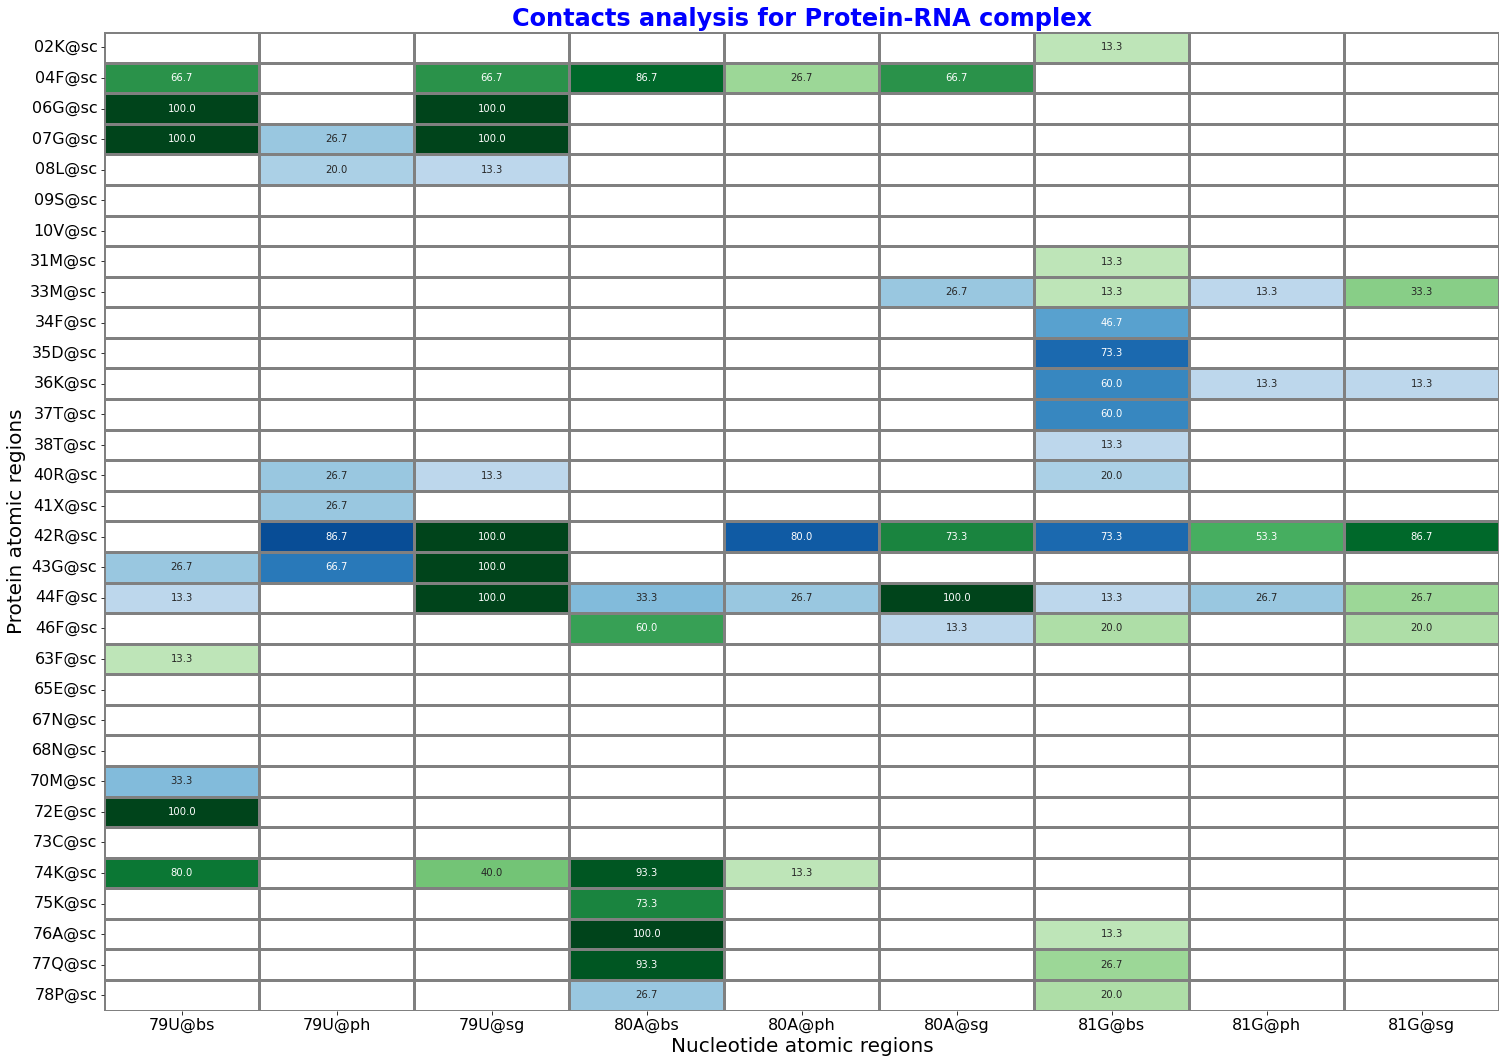

In [8]:
d = {0:'Greens',1:'Reds', 2: 'Blues', 3: 'Greys'}

f, ax = plt.subplots(figsize=(25, 18), facecolor='White')
for c, p in zip(df.native.unique(), d.values()):
    t = df.copy()
    t['Frames'] = np.where(t['native'].ne(c), np.nan, df['Frames'])
    ax = sns.heatmap(t.pivot('Prot','Nucl','Frames'), linewidths=3, linecolor='grey', cbar=False, cmap=d[c], annot=True, fmt='.1f', vmin=-20, vmax=100)

ax.set_title('Contacts analysis for Protein-RNA complex', fontsize=24, color= 'blue', fontweight='bold')
plt.xlabel('Nucleotide atomic regions', fontsize=20) 
plt.ylabel('Protein atomic regions', fontsize=20) 
plt.setp(ax.get_yticklabels(), fontsize=16) 
plt.setp(ax.get_xticklabels(), fontsize=16) 
plt.savefig(basename+'.png', facecolor=f.get_facecolor(), transparent=True)
plt.show()